In [8]:
%matplotlib inline 
from wmf import wmf
import numpy as np 
import pylab as pl
import pandas as pd 
import glob 

In [2]:
#Read the watershed structure
cu = wmf.SimuBasin(rute='Watershed.nc')

In [33]:
#Read the coordinates and ids of the IDEAM stations near the Miel Watershed.
coord, stations = wmf.read_map_points('rainfall_stations.shp', ListAtr=['id_value'])
stations = stations['id_value'].tolist()

#Function to obtain the id of the files in the folder.
def extract_ids(path):
    return path.split('/')[-1].split('_')[-1].split('.')[0]

# Get the list of stations in the folder.
ListStations = glob.glob('Path_to_stations/P_*.bin')
# Get the id of the stations in the folder
ids_inFile = list(map(extract_ids, ListStations))

#Get the shared stations
shared_stations, idx_sta, idx_File = np.intersect1d(np.array(stations), np.array(ids_inFile), return_indices=True)

In [84]:
#Read the information from pandas, and record the coordinates and ids of the stations that already has information.
Good_ids = []
Good_coord = []
Data = []
for idx_f, idx_s in zip(idx_File, idx_sta):
    try:
        d = pd.read_msgpack(ListStations[idx_f])
        if d['2016'].values.size == 366:
            Data.append(d['2016'].values)
            Good_ids.append(stations[idx_s])
            Good_coord.append(coord.T[idx_s])
            dates = d['2016'].index
    except:
        pass
Data = np.array(Data)
Rain = pd.DataFrame(Data.T, index=dates)
Good_coord = np.array(Good_coord)

In [91]:
#Interpolate rainfall with the IDEAM stations.
RainMean = cu.rain_interpolate_idw(Good_coord.T, Rain, 'Miel_rain_v1.bin', p = 3)

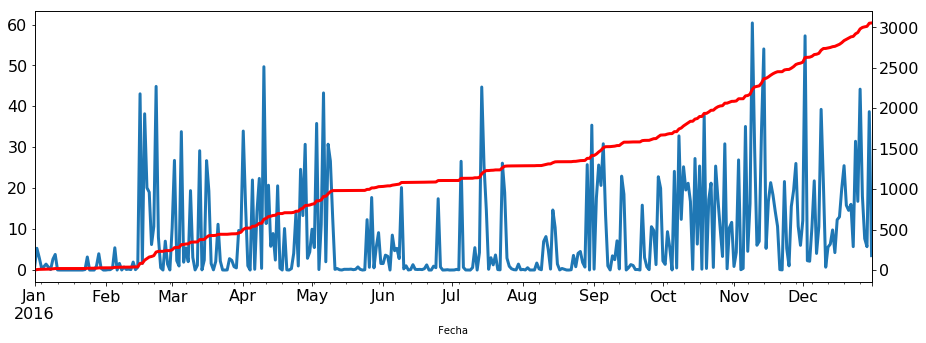

In [114]:
# Read the obtained table of the interpolated rainfall, it contains the record id of the binary and the mean rainfall.
Rain = wmf.read_rain_struct('Miel_rain_v1.hdr')
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.tick_params(labelsize = 16)
Rain[' Lluvia'].plot.line(fig = fig, ax = ax, lw = 3)
ax2 = ax.twinx()
ax2.tick_params(labelsize = 16)
ax2.set_xticklabels([])
Rain['acum'] = Rain[' Lluvia'].cumsum()
Rain['acum'].plot.line(fig = fig, ax = ax2, c = 'r',lw = 3)
pl.savefig('Annual_rainfall.png', bbox_inches = 'tight')

In [95]:
#Example of how to read the records of each record at the binary file.
RainTotal = np.zeros(cu.ncells)
for rec in Rain[' Record'].values:
    if rec > 1:
        rain, status = wmf.models.read_int_basin('Miel_rain_v1.bin', rec, cu.ncells)
        RainTotal += rain.astype(float) / 1000.

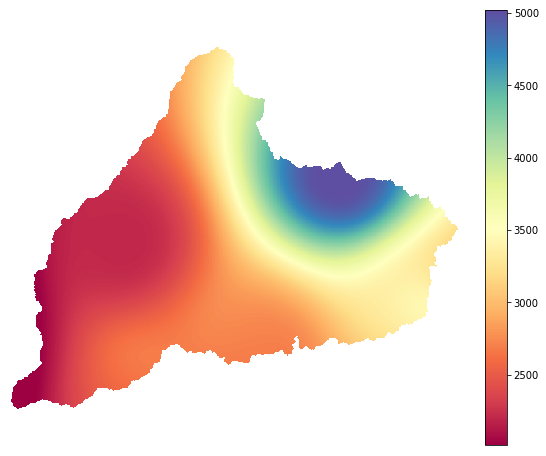

([-75.22657775878906,
  -74.92043475038372,
  5.259316444396973,
  5.5073056851979345],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5293c3d128>)

In [98]:
cu.Plot_basinClean(RainTotal, 
    show_cbar=True, 
    vmin = np.percentile(RainTotal, 1), 
    vmax = np.percentile(RainTotal, 99))